In [39]:
# import all revelant packages
from headers import *
outputFolder = 'output'

In [40]:
params = {
          'output': 'mPk',
          'P_k_max_h/Mpc': 100.,
          #'non linear' : 'HMCode',
          #'non linear' : 'halofit',
          'z_pk': '0.0,10',
          'A_s': 2.10732e-9,
          'n_s': 0.96824,
          'h': 0.6770,
          'omega_b': 0.02247,
          'omega_cdm': 0.11923}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

The experiment has noise $N = 1000 \text{ [Mpc/h]}^3$, which corresponds to $n = 0.001 \text{ [h/Mpc]}^{3}$. I'm evaluating the power spectrum at $z=1$, so I choose to have one redshift bin centered about $1$. I'm setting the bias to $b=1.5$.

In [41]:
exp = experiment(zmin=0.8,zmax=1.2,n=1e-3,nbins=1,sigma_z=0.,b=1.5)

I'm marginalizing over the parameters $\Omega_b, \Omega_c, h, \log(A_s), n_s, b, \text{ and }N$. I'm setting $k_\text{min}=10^{-4}\text{ h/Mpc}$ and $k_\text{max} = 0.2\text{ h/Mpc}$. I'm splitting the integral up into 200 $k$ and $\mu$ bins.

In [42]:
fishcast = fisherForecast(experiment=exp,cosmo=cosmo,params=params,khmax=0.2,Nk=200,Nmu=200)
fishcast.marg_params = np.array(['omega_b','omega_cdm','h','log(A_s)','n_s','b','N'])

To be consistent with Emanuele, I'm setting the volume to be exactly  $22.2 \text{ [Gpc/h]}^3$.

In [43]:
fishcast.Vsurvey = np.array([2.22e10])

In [44]:
F = fishcast.compute_Fisher_matrix()

MemoryError: Unable to allocate 11.9 GiB for an array with shape (40000, 40000) and data type float64

This is the Fisher matrix that Emanuele gets.

In [45]:
G = np.array([[4.45142819795e8 ,-1.80608721909e8,2.57753702061e7 ,-2.23233666861e7,-3.22526642248e7,-2.52605277442e7,-2988.75624629], 
[-1.80608721909e8,8.06533590801e7 ,-1.28862751558e7,9.44270032084e6 ,1.40800432912e7 ,1.06076456429e7 ,1289.01652831],  
[2.57753702061e7 ,-1.28862751558e7,2.3978617815e6 ,-1.47348867987e6,-2.161143888e6  ,-1.64203066749e6,-190.230007417],
[-2.23233666861e7,9.44270032084e6 ,-1.47348867987e6,1.17339333573e6 ,1.66084756506e6 ,1.32538653921e6 ,151.155238499], 
[-3.22526642248e7,1.40800432912e7 ,-2.161143888e6  ,1.66084756506e6 ,2.49476697721e6 ,1.8747200498e6  ,232.435626086],  
[-2.52605277442e7,1.06076456429e7 ,-1.64203066749e6,1.32538653921e6 ,1.8747200498e6  ,1.52559664834e6 ,176.835856178],  
[-2988.75624629  ,1289.01652831   ,-190.230007417  ,151.155238499   ,232.435626086   ,176.835856178   ,0.0258127871737]])

And here's the ratio of our forecasts.

In [46]:
from tabulate import tabulate
headers = list(fishcast.marg_params.copy())
table = tabulate(G/F,headers)
file = open(outputFolder+'/Fisher_ratio.dat','w')
file.write(table)
file.close()

print(table)

  omega_b    omega_cdm          h    log(A_s)        n_s         b          N
---------  -----------  ---------  ----------  ---------  --------  ---------
 1.20734       1.18613  -0.776819    1.18707    1.19447    1.19664   1.11199
 1.18613       1.15597  -1.02988     1.16445    1.16192    1.17467   1.07595
-0.776819     -1.02988   0.734315   -0.879986  -0.951856  -0.86578  -0.837807
 1.18707       1.16445  -0.879986    1.166      1.17123    1.17539   1.08628
 1.19447       1.16192  -0.951856    1.17123    1.16892    1.18146   1.08278
 1.19664       1.17467  -0.86578     1.17539    1.18146    1.18397   1.09436
 1.11199       1.07595  -0.837807    1.08628    1.08278    1.09436   1.08009


# Comparing derivatives at z=0

In [23]:
fishcast = fisherForecast(experiment=exp,cosmo=cosmo,params=params,khmax=40.,Nk=200,Nmu=200)
fishcast.marg_params = np.array(['omega_b','omega_cdm','h','log(A_s)','n_s','b','N'])

In [24]:
from twoPoint import*
z=0.
p_fid = compute_tracer_power_spectrum(fishcast, z)(fishcast.k,fishcast.mu)
d = fishcast.compute_dPdvecp(z)

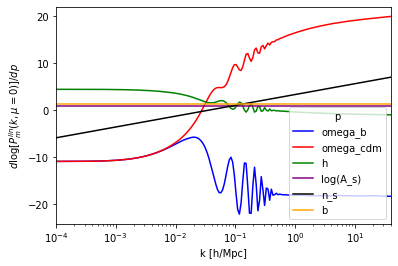

In [25]:
fishcast.pretty_plot(fishcast.k,d[0:-1]/p_fid,xlabel=r'k [h/Mpc]',ylabel=r'$d\log[P^{lin}_m(k,\mu=0)]/dp$',legendtitle='p',datalabels=fishcast.marg_params[0:-1],c=['b','r','g','purple','k','orange'],filename='output/derivatives')

# Comparing fiducial power spectra at z=0

In [26]:
data = np.genfromtxt(outputFolder+'/output_.11923_.02247_67.70_matterpower_z000.dat',
                     skip_header=1,
                     skip_footer=1,
                     names=True,
                     dtype=None,
                     delimiter=' ')

In [27]:
EmanK = np.array([data[i][0] for i in range(len(data))])
EmanP = np.array([data[i][3] for i in range(len(data))])

In [28]:
NoahP = np.array([cosmo.pk_lin(k*fishcast.params['h'],z)*fishcast.params['h']**3. for k in EmanK])

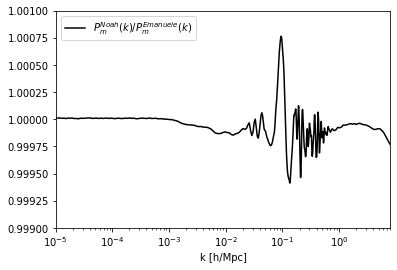

In [30]:
plt.semilogx(EmanK,NoahP/EmanP,label=r'$P^{Noah}_m(k)/P^{Emanuele}_m(k)$',c='k')
plt.xlabel(r'k [h/Mpc]')
plt.legend(loc=0)
plt.xlim(1e-5,8)
plt.ylim(0.999,1.001)
plt.savefig(outputFolder+'/pk_ratio.pdf')